In [1]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer

In [2]:
df = pd.read_csv('../data/singapore_airlines_reviews.csv')
df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0


<Axes: xlabel='rating', ylabel='count'>

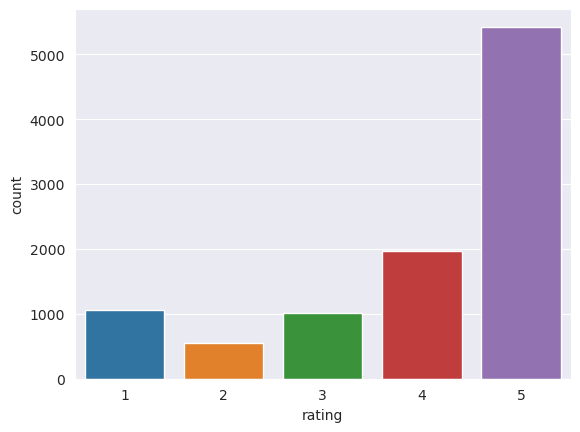

In [3]:
sns.countplot(df, x='rating')

Видно, что классы несбалансированные, поэтому будем использовать f1 меру

## Easy

In [4]:
def preprocess_text(text):
	return re.sub(r"[^\w\s]+", '', text).lower().split()

In [5]:
df.loc[102, 'text']

'Amazing cabin crew that was attached to the economy class seats.\nthey went above and beyond to help me find a lost earbud.\nI am extremely extremely grateful to the cabin crew for taking the time to help me on a very early christmas morning!!\nthank you so so so much to the cabin crew for helping me 😊😊'

Стоит заметить, что в отзывах есть эмодзи, однако preprocess_text уберёт их

In [6]:
def preprocess_sentence(text: str) -> str:
	prep_text = preprocess_text(text)
	return ' '.join(prep_text)

Удалим пунктуацию и приведём всё к нижнему регистру

In [7]:
df['text_preprocessed'] = df.text.map(lambda x: preprocess_sentence(x))

Пусть отзывы на 4 и 5 баллов будут положительные, а остальные отрицательные

In [8]:
df['rating_num'] = df['rating'].map(lambda x: 1 if x >= 4 else 0)

In [9]:
train, test = train_test_split(df, test_size=0.3, stratify=df['rating_num'], random_state=33)

bow = CountVectorizer()
x_train = bow.fit_transform(train['text_preprocessed'])
x_test = bow.transform(test['text_preprocessed'])

In [10]:
y_train = train['rating_num']
y_test = test['rating_num']

Попробуем сначала логистическую регрессию

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=10000)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)
f1_score(y_test, y_pred, average='macro')

0.8675656169836317

Теперь катбуст

In [12]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=1000, eval_metric='F1')

model.fit(x_train, y_train, verbose=False)

y_pred = model.predict(x_test)
f1_score(y_test, y_pred, average='macro')

0.850815519018284

Результаты несильно отличаются, но попробуем разбить на TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

x_train = tfidf.fit_transform(train['text_preprocessed'])
x_test = tfidf.transform(test['text_preprocessed'])

In [14]:
model = LogisticRegression(max_iter=1000)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)
f1_score(y_test, y_pred, average='macro')

0.8662114189470289

In [15]:
model = CatBoostClassifier(iterations=1000, eval_metric='F1')

model.fit(x_train, y_train, verbose=False)

y_pred = model.predict(x_test)
f1_score(y_test, y_pred, average='macro')

0.8609878256428105

Видно, что логистическая регрессия показывает лучший результат

## Medium

Попробуем сначала воспользоваться стэммингом и избавимсся от stop-words

In [16]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_sentence_stem(text: str) -> str:
	prep_text = preprocess_text(text)
	stemmer = SnowballStemmer("english")
	singles = [stemmer.stem(x) for x in prep_text if x not in stop_words]
	# ' '.join(list(map(stemmer.stem, preprocess_text(text))))
	return ' '.join(singles)

[nltk_data] Downloading package stopwords to /home/zahar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
df['text_stemmed'] = df['text'].map(lambda x: preprocess_sentence_stem(x))

In [18]:
train, test = train_test_split(df, test_size=0.3, stratify=df['rating_num'], random_state=33)

bow_stem = CountVectorizer()
x_train = bow_stem.fit_transform(train['text_stemmed'])
x_test = bow_stem.transform(test['text_stemmed'])

y_train = train['rating_num']
y_test = test['rating_num']

In [19]:
model_logreg_stem = LogisticRegression(max_iter=1000)

model_logreg_stem.fit(x_train, y_train)

y_pred = model_logreg_stem.predict(x_train)
print(f"train: {f1_score(y_train, y_pred, average='macro')}")
y_pred = model_logreg_stem.predict(x_test)
print(f"test: {f1_score(y_test, y_pred, average='macro')}")

train: 0.9850209449986219
test: 0.8566326373815915


In [20]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC

estimators = [('LogReg', LogisticRegression(max_iter=1000)),
			  ('SVC_lin', SVC(kernel='linear')),
			  ('SVC_rbf', SVC(kernel='rbf')),]
clf = StackingClassifier(estimators=estimators)

clf.fit(x_train, y_train)

y_pred = clf.predict(x_train)
print(f"train: {f1_score(y_train, y_pred, average='macro')}")
y_pred = clf.predict(x_test)
print(f"test: {f1_score(y_test, y_pred, average='macro')}")

train: 0.9701310345572588
test: 0.8658056916279324


In [21]:
model_catboost_stem = CatBoostClassifier(iterations=1000, eval_metric='F1')

model_catboost_stem.fit(x_train, y_train, verbose=False)

y_pred = model_catboost_stem.predict(x_train)
print(f"train: {f1_score(y_train, y_pred, average='macro')}")
y_pred = model_catboost_stem.predict(x_test)
print(f"test: {f1_score(y_test, y_pred, average='macro')}")

train: 0.9170574086263824
test: 0.8418543145868602


Результат несильно отличается от данных. на которых не был применён стемминг, попробуем применить лемматизацию

In [22]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def preprocess_sentence_lem(text: str) -> str:
	prep_text = preprocess_text(text)
	lemmatizer = WordNetLemmatizer()
	singles = [lemmatizer.lemmatize(x) for x in prep_text if x not in stop_words]
	return ' '.join(singles)

[nltk_data] Downloading package wordnet to /home/zahar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
df['text_lem'] = df['text'].map(lambda x: preprocess_sentence_lem(x))

In [24]:
train, test = train_test_split(df, test_size=0.3, stratify=df['rating_num'], random_state=33)

bow_lem = CountVectorizer()
x_train = bow_lem.fit_transform(train['text_lem'])
x_test = bow_lem.transform(test['text_lem'])
y_train = train['rating_num']
y_test = test['rating_num']

In [25]:
model_logreg_lem = LogisticRegression(max_iter=10000)

model_logreg_lem.fit(x_train, y_train)

y_pred = model_logreg_lem.predict(x_train)
print(f"train: {f1_score(y_train, y_pred, average='macro')}")
y_pred = model_logreg_lem.predict(x_test)
print(f"test: {f1_score(y_test, y_pred, average='macro')}")

train: 0.9899075111505982
test: 0.8601465031348293


In [26]:
model_catboost_lem = CatBoostClassifier(iterations=1000, eval_metric='F1')

model_catboost_lem.fit(x_train, y_train, verbose=False)

y_pred = model_catboost_lem.predict(x_train)
print(f"train: {f1_score(y_train, y_pred, average='macro')}")
y_pred = model_catboost_lem.predict(x_test)
print(f"test: {f1_score(y_test, y_pred, average='macro')}")

train: 0.9124549557086299
test: 0.844706717543704


In [27]:
from sklearn.tree import DecisionTreeClassifier
best_d = 0
best_s = 0
max_test = 0
best_model_decision_tree = None

for s in range(10, 100, 1):
	for d in range(5, 20, 1):
		model_decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth=d, min_samples_leaf=s)
		
		model_decision_tree.fit(x_train, y_train)
		y_pred = model_decision_tree.predict(x_train)
		train_f1 = f1_score(y_train, y_pred)
		y_pred = model_decision_tree.predict(x_test)
		test_f1 = f1_score(y_test, y_pred)
		if abs(train_f1 - test_f1) < 0.07 and max_test < test_f1:
			max_test = test_f1
			best_model_decision_tree = model_decision_tree
			print(f'train: {train_f1}\ntest: {test_f1}\ndepth: {d}\nsample_split: {s}')

train: 0.8854522567883474
test: 0.8839755738050116
depth: 5
sample_split: 10
train: 0.8857348185411428
test: 0.8851976450798991
depth: 6
sample_split: 10
train: 0.8883585255900291
test: 0.8863542098714227
depth: 7
sample_split: 10
train: 0.8925902583956065
test: 0.8874367622259696
depth: 8
sample_split: 10
train: 0.8943162431534524
test: 0.887581424669048
depth: 9
sample_split: 10
train: 0.8998551249547266
test: 0.8880423280423281
depth: 10
sample_split: 10
train: 0.9119199777716033
test: 0.8901783795400816
depth: 15
sample_split: 10
train: 0.9101384629681256
test: 0.8914778856526431
depth: 15
sample_split: 11
train: 0.903673544924586
test: 0.8917748917748918
depth: 15
sample_split: 18
train: 0.9061458718992966
test: 0.8930192349254376
depth: 17
sample_split: 18
train: 0.9053916581892166
test: 0.8934885726606295
depth: 17
sample_split: 19
train: 0.9040333796940196
test: 0.8943159714717959
depth: 17
sample_split: 21


Видно, что лемматизация не дала сильного прироста к качеству моделей. Логистическая регрессия и катбуст показали хороший результат при простом препроцессинге(удаление пунктуации и приведение всего к одному регистру), стемминге и лемматизации. Стоит отметить, что decision tree дал результат чуть лучше, чем катбуст, не смотря на большое количество фичей. Также ансамбль из лог регресси и svc с линейным и Гауссовым ядром показалс себя не хуже других моделей

Пайплайн для теста моделей

In [28]:
def pipeline(df, model, prep_type = 'lem'):
	assert prep_type in ['lem', 'stem']
	if prep_type == 'lem':
		df['prep_text'] = df['text'].map(lambda x: preprocess_sentence_lem(x))
		test = bow_lem.transform(df['prep_text'])
	else:
		df['prep_text'] = df['text'].map(lambda x: preprocess_sentence_stem(x))
		test = bow_stem.transform(df['prep_text'])
	return model.predict(test)

In [29]:
bad_comm_1 = 'I had the worst experience flying with this airline. The customer service was terrible, the flight was delayed multiple times without any clear explanation, and the seats were incredibly uncomfortable. The food served on board was bland and overpriced, and the entertainment options were outdated. I would not recommend this airline to anyone looking for a pleasant and stress-free travel experience.'
bad_comm_2 = 'I had an absolutely terrible experience flying with this airline. The staff was rude and unhelpful, the flight was delayed without any clear explanation, and the seats were incredibly uncomfortable. The food was subpar and overpriced, and the overall service was lackluster. I would not recommend this airline to anyone looking for a pleasant and stress-free travel experience. Avoid at all costs!'
good_comm_1 = 'I had a fantastic experience flying with this airline. The customer service was top-notch, with friendly and helpful staff throughout my journey. The flight departed on time and arrived early, making for a smooth and efficient travel experience. The seats were comfortable and spacious, allowing me to relax and enjoy the flight. The food served on board was delicious and reasonably priced, and there were plenty of entertainment options to choose from. I would highly recommend this airline to anyone looking for a pleasant and enjoyable travel experience'
good_comm_2 = 'I recently flew with Airline and was thoroughly impressed. From the efficient check-in to the comfortable and well-appointed aircraft, every aspect of my journey was exceptional. The attentive flight attendants ensured I had a relaxing and enjoyable flight. I highly recommend Airline Name for their reliable service and commitment to passenger satisfaction.'

test_df = pd.DataFrame({'text': [bad_comm_1, good_comm_1, good_comm_2, bad_comm_2], 'rating_num': [0, 1, 1, 0]})

test_df

,text,rating_num
0,I had the worst experience flying with this ai...,0
1,I had a fantastic experience flying with this ...,1
2,I recently flew with Airline and was thoroughl...,1
3,I had an absolutely terrible experience flying...,0


In [30]:
pipeline(test_df, model_logreg_lem, 'lem')

array([0, 1, 1, 0])

In [31]:
pipeline(test_df, model_catboost_lem, 'lem')

array([0, 1, 1, 0])

In [32]:
pipeline(test_df, model_catboost_stem, 'stem')

array([0, 1, 1, 0])

In [33]:
pipeline(test_df, best_model_decision_tree, 'lem')

array([0, 1, 1, 0])

In [34]:
pipeline(test_df, model_logreg_stem, 'stem')

array([0, 1, 1, 0])

In [35]:
pipeline(test_df, clf, 'stem')

array([0, 1, 1, 0])

Видно, что все модели справились с задачей, причём не зависимо от того, применили к данным стемминг или лемматизацию. Стоит заметить, что у всех моделей качество отличается несильно, но decision tree показывает себя лучше остальных, особенно подобрав параметры так, чтобы f1 на тесте была наибольшей и разница между f1 на test и train была < 0.07(можно выбрать и другое значение), причём разница между test и train и decision tree наименьшая, если сравнивать с остальными моделями